In [1]:
import torch
#앞선 노드들에서의 정보가 들어올 때 layer에 존재하는 가중치에 행렬곱을 시키고 편향을 더해주는 작업을 통해서 정밀하게 만들 수 있음
# 이러한 결과는 활성화함수 (activation function)을 통해서 결과값 출력함
# 이 프로젝트에서는 지도학습, 그중에서도 분류를 하는 간단한 인공지능을 만들어본다
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
import torch.nn.functional as F

In [2]:
# make dataset 
# train using in training 
# test using in validation

n_dim = 2
x_train,y_train = make_blobs(n_samples = 80, n_features=n_dim,centers=[[1,1],[-1,-1],[1,-1],[-1,1]],shuffle = True, cluster_std = 0.3)

x_test,y_test = make_blobs(n_samples = 20, n_features=n_dim,centers=[[1,1],[-1,-1],[1,-1],[-1,1]],shuffle = True, cluster_std = 0.3)

#사이킷런의 make_blobs함수를 이용해서 데이터를 2차ㅝㄴ 벡터 형태로 만들고 트레이닝엔 80, 테스팅엔 20개를 넣음 
#여기서 만들어진 레이블데이터는 각 데이터 한 점 한 점이 몇번째 클러스터에 속해있는지 알려주는 인덱스임
# 이 예제에서는 4개의 클러스터를 만들어냈다.


In [3]:
# 학습시킬 신경망 모델은 두가지 레이블만 예측하는 기본적인 모델이기 때문에 4개의 레이블을 2개로 합치는 과정을 만들어야함
def label_map(y_,from_,to_):
    y = np.copy(y_)
    for f in from_:
        y[y_==f] = to_
    return y

y_train = label_map(y_train,[0,1],0)
y_train = label_map(y_train,[2,3],1)
y_test = label_map(y_test,[0,1],0)
y_test = label_map(y_test,[2,3],0)


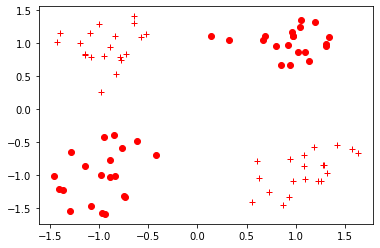

In [4]:
#데이터가 제대로 레이블링 되었는지 맷플롯립으로 확인
def vis_data(x,y=None,c='r'):
    if y is None:
        y = [None]*len(x)
    for x_,y_ in zip(x,y):
        if y_ is None:# 만약에 레이블이 map안되어있다면?
            plt.plot(x_[0],x_[1],'*',markerfacecolor='none',markeredgecolor=c)
        else:#일반적인 경우
            plt.plot(x_[0],x_[1],c+'o' if y_ == 0 else c+'+')
plt.figure()
vis_data(x_train,y_train,c='r')
plt.show()

In [5]:
#생성한 넘파이 벡터 형식 데이터를 파이토치 텐서로 변경해줌

x_train = torch.FloatTensor(x_train)
x_test = torch.FloatTensor(x_test)
y_train = torch.FloatTensor(y_train)
y_test = torch.FloatTensor(y_test)

In [6]:
#신경망 모델 구현하기
#파이토치에서 신경망을 보통 torch.nn.Module을 상속받는 파이썬 클래스로 정의함
#이렇게 상속받으면 파이토치 프레임워크에 있는 도구들을 사용가능함

class NeuralNet(torch.nn.Module):
    #신경망의 구조와 동작을 정의하는 생성자를 클래스에 정의함
    #이 함수는 파이썬에서 객체가 갖는 속성값을 초기화하는 역할로 객체가 생성될때 자동으로 호출
    #super()함수를 부르면 만든 NeuralNet클래스는 파이토치의 nn.Module 클래스의 속성들을 가지고 초기화된다.
    def __init__(self,input_size,hidden_size):
        super(NeuralNet,self).__init__()
        # size는 입력 데이터 차원
        self.input_size = input_size
        self.hidden_size = hidden_size
        #입력된 데이터가 인공신경망을 통과하면서 거치는 연산 정의
        self.linear_1 = torch.nn.Linear(self.input_size,self.hidden_size) # 가중치와 편향이 들어가있는 연산과정
        self.relu = torch.nn.ReLU() # 활성화함수
        self.linear_2 = torch.nn.Linear(self.hidden_size,1) # 가중치와 편향이 들어가있는 연산과정
        self.sigmoid = torch.nn.Sigmoid() # 활성화함수
        
    def forward(self,input_tensor):
        linear1 = self.linear_1(input_tensor)
        relu = self.relu(linear1)
        linear2 = self.linear_2(relu)
        output = self.sigmoid(linear2)
        return output

In [7]:
# 신경망 객체를 생성하고 학습에 필요한 여러 변수와 알고리즘을 정의함
model = NeuralNet(2,5) # input size 2 hidden size 5
learning_rate = 0.03
criterion = torch.nn.BCELoss()#BCELoss is binary cross entropy
epochs = 2000
optimizer = torch.optim.SGD(model.parameters(),lr = learning_rate) # optimizer는 step함수를 부를때마다 가중치를 학습률만큼 갱신함
#따라서 model.parameters를 함수로 추출한 모델 내부의 가중치와 학습률을 입력함


In [8]:
model.eval()
test_loss_before = criterion(model(x_test).squeeze(),y_test) # 모델의 결과값과 레이블값의 차원을 맞춰주기 위해서 squeeze함수를 사용함
print('before training, test loss is {}'.format(test_loss_before.item()))# item함수는 텐서 속의 숫자를 스칼라 값으로 반환함


before training, test loss is 0.84453946352005


In [13]:
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad() # epoch마다 새로운 경사값을 계산할 것이므로 zerograd 함수를 호출해 경사값을 0으로 만들어줌
    train_output = model(x_train)
    train_loss = criterion(train_output.squeeze(),y_train)
    if epoch % 100 ==0: #100번마다
        print('train loss at {} is {})'.format(epoch,train_loss.item()))
        
    #오차 함수를 가중치로 미분하여 오차가 최소가 되는 방향을 구하고 그 방향으로 모델을 학습률만큼 이동시킴, 다음 두줄이 핵심 코드
    train_loss.backward()
    optimizer.step()


train loss at 0 is 0.3518521785736084)
train loss at 100 is 0.35174697637557983)
train loss at 200 is 0.35164719820022583)
train loss at 300 is 0.35154736042022705)
train loss at 400 is 0.35145407915115356)
train loss at 500 is 0.35136356949806213)
train loss at 600 is 0.351278692483902)
train loss at 700 is 0.35119205713272095)
train loss at 800 is 0.3511105477809906)
train loss at 900 is 0.351034015417099)
train loss at 1000 is 0.35095494985580444)
train loss at 1100 is 0.35088247060775757)
train loss at 1200 is 0.35081300139427185)
train loss at 1300 is 0.3507414162158966)
train loss at 1400 is 0.35067620873451233)
train loss at 1500 is 0.35061103105545044)
train loss at 1600 is 0.3505462408065796)
train loss at 1700 is 0.35048750042915344)
train loss at 1800 is 0.35042789578437805)
train loss at 1900 is 0.3503722548484802)


In [17]:
test_loss = criterion(torch.squeeze(model(x_test)),y_test)
print(test_loss.item())

2.2000880241394043


In [18]:
# 학습된 모델을 state_dict함수 형태로 바꿔주고 .pt파일로 저장
# state_dict 함수는 모델 내 가중치들이 딕셔너리 형태로 {연산 이름 : 가중치텐서, 편향텐서}와 같이 표현된 데이터
torch.save(model.state_dict(),'./model.pt')
print('state_dict format of the model : {}'.format(model.state_dict()))

state_dict format of the model : OrderedDict([('linear_1.weight', tensor([[-0.0476, -0.4048],
        [-2.3075, -1.4825],
        [-2.4248,  1.2868],
        [-0.0027,  0.0152],
        [-0.9331,  0.4636]])), ('linear_1.bias', tensor([-0.6885, -0.7902, -1.0859, -0.2919, -0.3830])), ('linear_2.weight', tensor([[ 0.4237, -2.7409,  2.8755,  0.0171,  0.8104]])), ('linear_2.bias', tensor([-0.0020]))])


In [21]:
# 이렇게 저장한 파일을 나중에 불러와서 새로운 신경망 객체에 이미 학습된 모델의 가중치를 곧바로 적용할 수 있다.
# 새로운 모델인 new_model을 생성하고 앞서 학습한 모델의 가중치를 입력해보자

new_model = NeuralNet(2,5)
new_model.load_state_dict(torch.load('./model.pt'))

<All keys matched successfully>

In [22]:
new_model.eval()
print('벡터 [-1, 1]이 레이블 1을 가질 확률은{}'.format(new_model(torch.FloatTensor([-1,1])).item()))

벡터 [-1, 1]이 레이블 1을 가질 확률은0.9997451901435852
